# Next basket recommendation

The task of next basket recommendation is to predict a content of customers basket at their future purchase.

Task has been assigned as a competition among the students who took the Algorithms of data mining course at Faculty of Information Technology @ Czech Technical University in Prague.

### Scoring function

The competition has been divided into 2 rounds. The difference between rounds is the used scoring function. 1st round scoring function is Jaccard similarity coefficient

$J(A,B) = \frac{ |A \cap B| }{ |A \cup B| }$,

where A is a real basket and B is a predicted one. Final score is a mean of $J(A,B)$ over all predictions. 2nd round scoring function is Generalized Jaccard similarity coefficient over multisets

$J_g(A,B) = \frac{ \sum_i min(a_i, b_i) }{ \sum_i max(a_i, b_i) }$,

where $A$ is a real basket and $B$ is a predicted one. $a_i$ (resp. $b_i$) is number of occurences of $i$-th in $A$ (resp. $B$). Final score is a mean of $J_g(A,B)$ over all predictions. Generalized jaccard index takes into account cases where there is multiple occurrences of same products in one basket. Therefore the scoring function is stricter.

Score in 1st rnd: TBA

Position among others 1st rnd: TBA

Score in 2nd rnd: TBA

Position among others 2nd rnd: TBA

### Disclaimer

Unfortunately I cannot provide the data for the problem as to avoid any legal issues. The data has been provided by a external company in collaboration with the university.



Even though I cannot provide the dataset I will still try to capture my thought process and all the ideas and examples will be shown.


## Dataset

We have been provided with 2 types of csv files.

First file contains 3 columns that together create a order history. The columns are `userid`, `date` and `itemids`. Columns are self-explanatory. `userid` is an ID number of an user, `date` is a date of a purchase and `itemids` is a space separated list of product IDs. Order history files come in 2 sizes. First, the smaller one, contains 1 700 000+ rows. Second file contains total of 8 800 000+ of data.

| userid 	| date       	| itemids           	|
|--------	|------------	|-------------------	|
| 12345  	| 1995-30-7  	| 11111 22222       	|
| 777777 	| 2022-1-1   	| 12314             	|
| 425645 	| 2020-12-31 	| 45646 46511 11111 	|

Second file contains information about products. Each row represents one product. There is 25+ features about each product. Total number of products is 1426. The thoughts about feature selection for products is described later.

| productid 	| features.... 	|
|-----------	|--------------	|
| 11111     	| features     	|
| 22222     	| features     	|


## Data preprocessing

First, I work with smaller dataset. Scaling to full dataset will be done in the end.

In [39]:
# Packages used to preprocess the data
import pandas as pd

For feature engineering I decided to use Feature Tools.

In [13]:
def preprocess_train_file(rel_path):
    df = pd.read_csv(rel_path)

    df =( df.assign(
                date=lambda x: pd.to_datetime(x['date'], infer_datetime_format=True),
        )
        .rename(columns={'userid':'user_id'})
        # Creating ids for every order
        .set_index(['date'])
        .sort_index()
        .assign(
            id=range(0,len(df))
        )
        #
        .astype({'user_id':'uint32','id':'uint32'})
        .reset_index()
    )

    df[['id','user_id','date']].to_parquet(f'{rel_path[:-4]}_orders.parquet',engine='fastparquet')

    df =( df.drop(columns=['user_id','date'])
        .assign(product_id=lambda x: x['itemids'].str.split())
        .rename(columns={'id':'order_id'})
        .drop(columns='itemids')
        .explode('product_id')
        .astype({'product_id':'uint16'})
        .assign(
            id=lambda x: range(0,len(x))
        )
        .astype({'id':'uint32'})
    )
    df.index = pd.RangeIndex(len(df.index))

    df.to_parquet(f'{rel_path[:-4]}_orders_products.parquet',engine='fastparquet')


In [16]:
#preprocess_train_file('data/train100k.csv')


In [17]:
def preprocess_products_file(rel_file_path):
    df = pd.read_csv('data/items.csv')
    columns_to_drop = {*df.columns[(df.count() < 0.5 * len(df))].to_list()}
    columns_to_drop |= {'declaration_of_ingredients', 'description', 'allergens', 'special_ingredients'}
    columns_to_drop |= {*df.columns[df.columns.str.contains('_main|_sub', regex=True)].to_list()}

    df = df.drop(columns=columns_to_drop)
    df = (
        df.astype(
            {
                **dict.fromkeys(df.columns[(df.nunique() < 60)].to_list(), 'category'),
                **{'itemid':'uint16'}
            }
        )
        .rename(columns={'itemid':'product_id'})
    )
    df.to_parquet('data/products.parquet',engine='fastparquet')

In [18]:
#preprocess_products_file('data/items.csv')

## Entity set

In [ ]:
import featuretools as ft
import featuretools.primitives as pr

In [19]:
orders = pd.read_parquet('data/train100k_orders.parquet')
orders_products = pd.read_parquet('data/train100k_orders_products.parquet')
products = pd.read_parquet('data/products.parquet')

In [20]:
es = ft.EntitySet(id='next_basket_data')

es.add_dataframe(
    dataframe_name='orders',
    dataframe=orders,
    index='id',
    time_index='date'
)

es.add_dataframe(
    dataframe_name='orders_products',
    dataframe=orders_products,
    index='id'
)

es.add_dataframe(
    dataframe_name='products',
    dataframe=products,
    index='product_id'
)

In [ ]:
es.add_relationship('products', 'product_id', 'orders_products', 'product_id')
es.add_relationship('orders', 'id', 'orders_products', 'order_id')

es.normalize_dataframe('orders','users','user_id')

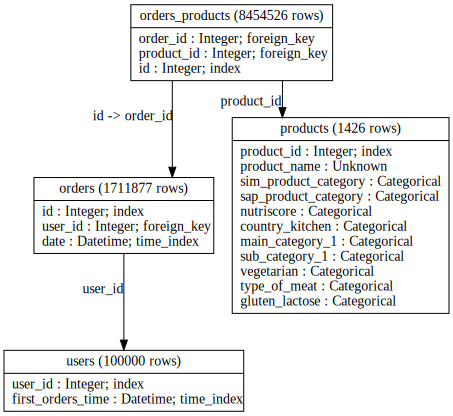

In [21]:
es.plot()

In [ ]:
es.add_interesting_values(dataframe_name="products",
                          values={
                              'vegetarian': ['t', 'f'],
                              'sim_product_category': ['Fish','Ready-made','Snacks', 'Non-food','Vegetables','Potato products','Poultry','Fruit','Other frozen food','Meat','Non-frozen food','Bakery','Ice-cream','Milk products','Desserts']
                          })

In [22]:
cutoff = orders[['user_id','date']].rename(columns={'date':'time'})
cutoff

,user_id,time
0,4679611,2019-01-02
1,4469703,2019-01-02
2,2718339,2019-01-02
3,5951243,2019-01-02
4,9889402,2019-01-02
...,...,...
1711872,4631009,2020-12-30
1711873,8480443,2020-12-30
1711874,8381298,2020-12-30
1711875,5086174,2020-12-30


In [37]:
features = ft.dfs(entityset=es,
                  target_dataframe_name='users',
                  agg_primitives=[
                      'sum', 'max', 'min', 'mean', 'count',
                      'num_unique', 'mode', pr.AvgTimeBetween(unit='days'),
                  ],
                  trans_primitives=[
                      'day','month','weekday','cum_mean','year'
                  ],
                  cutoff_time=cutoff,
                  max_depth=4,
                  n_jobs=1,
                  ignore_columns={'users':['first_orders_time']},
                  verbose=True,
                  features_only=True,
                  include_cutoff_time=False)

Built 302 features


## Machine learning

Work in progress

https://scikit-learn.org/stable/modules/multiclass.html

## Scaling to larger dataset